In [107]:
### Code Cleaning TBD
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import category_encoders
from sklearn.model_selection import GroupKFold,TimeSeriesSplit
import hyperopt
from hyperopt import hp, tpe, STATUS_OK, Trials
import pickle
import gensim
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import time

In [108]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test_QyjYwdj.csv')

In [109]:
campaign_data=pd.read_csv('campaign_data.csv')

In [110]:
coupon_item_mapping=pd.read_csv('coupon_item_mapping.csv')

In [111]:
customer_demographics=pd.read_csv('customer_demographics.csv')

In [112]:
item_data=pd.read_csv('item_data.csv')

In [113]:
customer_transaction_data=pd.read_csv('customer_transaction_data.csv')

In [114]:
train_campaign=train.merge(campaign_data,on='campaign_id')
test_campaign=test.merge(campaign_data,on='campaign_id')

In [115]:
train_campaign['start_date']=pd.to_datetime(train_campaign['start_date'],dayfirst=True)
train_campaign['end_date']=pd.to_datetime(train_campaign['end_date'],dayfirst=True)
test_campaign['start_date']=pd.to_datetime(test_campaign['start_date'],dayfirst=True)
test_campaign['end_date']=pd.to_datetime(test_campaign['end_date'],dayfirst=True)

In [116]:
coupon_item_data=coupon_item_mapping.merge(item_data,on='item_id',how='left')
unique_item_data=pd.DataFrame(coupon_item_data.groupby('coupon_id')['item_id','brand','brand_type'].agg(['unique']).reset_index())
unique_item_data.columns=['coupon_id','item_id_uniq','brand_uniq','brand_type_uniq']
unique_item_data['item_id_uniq']=[len(i) for i in unique_item_data['item_id_uniq']]
unique_item_data['brand_uniq']=[len(i) for i in unique_item_data['brand_uniq']]
unique_item_data['brand_type_uniq']=[len(i) for i in unique_item_data['brand_type_uniq']]

In [117]:
train_demo=train_campaign.merge(customer_demographics,on='customer_id',how='left')
test_demo=test_campaign.merge(customer_demographics,on='customer_id',how='left')

In [118]:
train_demo['family_size']=train_demo['family_size'].replace({'1':1, '2':2, '3':3, '4':4 ,'5+':5})
train_demo['no_of_children']=train_demo['no_of_children'].replace({'1':1, '2':2, '3+':3})
train_demo['age_range']=train_demo['age_range'].replace({'18-25':1,'26-35':2,'36-45':3,'46-55':4,'56-70':5,'70+':6})
train_demo['marital_status']=train_demo['marital_status'].replace({'Married':0,'Single':1})
test_demo['family_size']=test_demo['family_size'].replace({'1':1, '2':2, '3':3, '4':4 ,'5+':5})
test_demo['no_of_children']=test_demo['no_of_children'].replace({'1':1, '2':2, '3+':3})
test_demo['age_range']=test_demo['age_range'].replace({'18-25':1,'26-35':2,'36-45':3,'46-55':4,'56-70':5,'70+':6})
test_demo['marital_status']=test_demo['marital_status'].replace({'Married':0,'Single':1})

In [119]:
lb=LabelEncoder()
train_demo['campaign_type']=lb.fit_transform(train_demo['campaign_type'])
test_demo['campaign_type']=lb.transform(test_demo['campaign_type'])

In [120]:
cols=['campaign_type','age_range',
       'marital_status', 'rented', 'family_size', 'no_of_children',
       'income_bracket']

In [121]:
uniq_items=coupon_item_mapping['item_id'].unique()
relevant_transactions=customer_transaction_data[customer_transaction_data['item_id'].isin(uniq_items)]
relevant_transactions['date']=pd.to_datetime(customer_transaction_data['date'],dayfirst=True)
customer_transaction_data['date']=pd.to_datetime(customer_transaction_data['date'],dayfirst=True)

/home/Mahir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
item_brands=coupon_item_data[['item_id','brand']].drop_duplicates()
relevant_transactions=relevant_transactions.merge(item_brands,on='item_id',how='left')
# relevant_transactions=customer_transaction_data
# relevant_transactions['date']=pd.to_datetime(customer_transaction_data['date'],dayfirst=True)

In [123]:
start=time.time()
count=0
df_main=pd.DataFrame()
for i in train_demo['start_date'].unique():
    count=count+1
    print(count)
    train_chunk=train_demo[train_demo.start_date==i]
#     log_temp=relevant_transactions
    log_temp=relevant_transactions[relevant_transactions.date<i]
    log_temp['ratio']=abs(log_temp['coupon_discount']/log_temp['selling_price'])
    customer_uniq_item_count=log_temp.groupby(['customer_id'])['item_id'].nunique().reset_index()
    customer_uniq_item_count.columns=['customer_id','uniq_item_count']
    customer_item_count=log_temp.groupby(['customer_id'])['item_id'].count().reset_index()
    customer_item_count.columns=['customer_id','item_count']
    customer_total_item_count=log_temp.groupby('customer_id')['quantity'].sum().reset_index()
    customer_total_item_count.columns=['customer_id','total_item_count']
    discounts_count_coupon=log_temp[log_temp['coupon_discount']<0].groupby('customer_id')['coupon_discount'].count().reset_index()
    discounts_count_coupon.columns=['customer_id','disc_count']
    discounts_count_other=log_temp[log_temp['other_discount']<0].groupby('customer_id')['other_discount'].count().reset_index()
    discounts_count_other.columns=['customer_id','disc_count_other']
    cust_price=log_temp.groupby(['customer_id'])['selling_price'].agg(['min','max','mean','sum']).reset_index()
    cust_price.columns=['customer_id','min_price','max_price','mean_price','sum']
    discounts_feats_coupon=log_temp[log_temp['coupon_discount']<0].groupby('customer_id')['coupon_discount'].agg(['min','max','mean','sum']).reset_index()
    discounts_feats_coupon.columns=['customer_id','min_disc','max_disc','mean_disc','sum_disc']
    mean_disc_to_price=log_temp[log_temp['coupon_discount']<0].groupby('customer_id')['ratio'].agg(['min','max','mean']).reset_index()
    mean_disc_to_price.columns=['customer_id','min_rat','max_rat','mean_rat']
    uniq_brands=log_temp.groupby(['customer_id'])['brand'].nunique().reset_index()
    uniq_brands.columns=['customer_id','uniq_brand_count']
    train_chunk=train_chunk.merge(uniq_brands,on='customer_id',how='left')
    train_chunk=train_chunk.merge(customer_uniq_item_count,on='customer_id',how='left')
    train_chunk=train_chunk.merge(customer_item_count,on='customer_id',how='left')
    train_chunk=train_chunk.merge(discounts_count_coupon,on='customer_id',how='left')
    train_chunk=train_chunk.merge(discounts_count_other,on='customer_id',how='left')
    train_chunk=train_chunk.merge(cust_price,on='customer_id',how='left')
    train_chunk=train_chunk.merge(discounts_feats_coupon,on='customer_id',how='left')
    train_chunk=train_chunk.merge(mean_disc_to_price,on='customer_id',how='left')
    train_chunk=train_chunk.merge(customer_total_item_count,on='customer_id',how='left')
    train_chunk['min_disc']=abs(train_chunk['min_disc'])
    train_chunk['max_disc']=abs(train_chunk['max_disc'])
    train_chunk['mean_disc']=abs(train_chunk['mean_disc'])
    train_chunk['sum_disc']=abs(train_chunk['sum_disc'])
    df_main=pd.concat([df_main,train_chunk])
end=time.time()
print(end-start)

1


/home/Mahir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
9.755752563476562


In [124]:
cols=['campaign_type','age_range',
       'marital_status', 'rented', 'family_size', 'no_of_children',
       'income_bracket', 'uniq_item_count', 'item_count', 'disc_count',
       'disc_count_other', 'min_price', 'max_price', 'mean_price', 'sum',
       'min_disc', 'max_disc', 'mean_disc', 'sum_disc', 'min_rat', 'max_rat',
       'mean_rat', 'total_item_count','encoding_coupon','rat','item_id_uniq',
       'brand_uniq', 'brand_type_uniq','past_action','no_of_users','uniq_brand_count','no_of_previous_clicks','match','match_rate','brand_1', 'brand_2','brand_3', 'brand_4', 'brand_5', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']
# cols=['campaign_type','age_range',
#        'marital_status', 'rented', 'family_size', 'no_of_children',
#        'income_bracket', 'uniq_item_count', 'item_count', 'disc_count',
#        'disc_count_other', 'min_price', 'max_price', 'mean_price', 'sum',
#        'min_disc', 'max_disc', 'mean_disc', 'sum_disc', 'min_rat', 'max_rat',
#        'mean_rat', 'total_item_count','encoding_coupon','rat','item_id_uniq','uniq_brand_count','no_of_previous_clicks','lab','rat_lol','brand_1', 'brand_2',
#        'brand_3', 'brand_4', 'brand_5', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']

In [125]:
df_main=df_main.sort_values(by='start_date')

In [126]:
df_target=pd.DataFrame()
for i in df_main['start_date'].unique():
    chk=df_main[df_main.start_date<i]
    chk_2=df_main[df_main.start_date==i]
    target_enc = chk.groupby(by = ['coupon_id'])['redemption_status'].agg(['sum','count']).reset_index()
    target_enc.columns = ['coupon_id',"target_sum","target_count"]
    target_enc['encoding_coupon'] = target_enc.target_sum/target_enc.target_count
    target_enc_1 = chk.groupby(by = ['customer_id'])['redemption_status'].agg(['sum','count']).reset_index()
    target_enc_1.columns = ['customer_id',"target_sum_1","target_count_1"]
    target_enc_1['encoding_customer'] = target_enc_1.target_sum_1/target_enc_1.target_count_1
    chk_2=chk_2.merge(target_enc,on='coupon_id',how='left')
    chk_2=chk_2.merge(target_enc_1,on='customer_id',how='left')
    try:
        people_coupons=chk[chk['redemption_status']==1].groupby('coupon_id')['customer_id'].nunique().reset_index()
        people_coupons.columns=['coupon_id','no_of_users']
        chk_2=chk_2.merge(people_coupons,on='coupon_id',how='left')
    except:
        pass
    df_target=pd.concat([df_target,chk_2])

/home/Mahir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [127]:
target_enc1 = df_target.groupby(by = ['coupon_id'])['redemption_status'].agg(['sum','count']).reset_index()
target_enc1.columns = ['coupon_id',"target_sum1","target_count1"]
target_enc1['encoding'] = target_enc1.target_sum1/target_enc1.target_count1
df_target=df_target.merge(target_enc1,on='coupon_id',how='left')

In [128]:
coupon_item_mapping['item_id_str']=coupon_item_mapping['item_id'].apply(str)
prep_for_embeddings_items=coupon_item_mapping.groupby('coupon_id')['item_id_str'].unique().reset_index()
main_item=[]
for i in prep_for_embeddings_items['item_id_str']:
    main_item.append(list(i))
model_item=gensim.models.Word2Vec(main_item,size=20,window=5,min_count=1,workers=10)
embeddings_items={}
for i in list(model_item.wv.vocab):
    embeddings_items[i]=model_item.wv[i]
pickle.dump(embeddings_items,open('embedding_item','wb'),protocol=4)
embeddings_items=pickle.load(open('embedding_item','rb'))
coupon_item_data['brand_str']=coupon_item_data['brand'].apply(str)
prep_for_embeddings_brands=coupon_item_data.groupby('coupon_id')['brand_str'].unique().reset_index()
main_brand=[]
for i in prep_for_embeddings_brands['brand_str']:
    main_brand.append(list(i))
model_brand=gensim.models.Word2Vec(main_brand,size=20,window=5,min_count=1,workers=10)
embeddings_brand={}
for i in list(model_brand.wv.vocab):
    embeddings_brand[i]=model_brand.wv[i]
pickle.dump(embeddings_brand,open('embedding_brand','wb'),protocol=4)
embeddings_brand=pickle.load(open('embedding_brand','rb'))
fin_item=[]
for i in main_item:
    fin_vect_item=[]
    for j in i:
        vect_item=embeddings_items[j]
        fin_vect_item.append(vect_item)
    fin_item.append(list(np.mean(fin_vect_item,axis=0)))
embeds_item=pd.DataFrame(fin_item)
embeds_item.columns=['item_'+str(i) for i in range(1,21)]
fin_brand=[]
for i in main_brand:
    fin_vect_brand=[]
    for j in i:
        vect_brand=embeddings_brand[j]
        fin_vect_brand.append(vect_brand)
    fin_brand.append(list(np.mean(fin_vect_brand,axis=0)))
embeds_brand=pd.DataFrame(fin_brand)
embeds_brand.columns=['brand_'+str(i) for i in range(1,21)]
embeds_brand['coupon_id']=prep_for_embeddings_brands['coupon_id']
embeds_item['coupon_id']=prep_for_embeddings_items['coupon_id']
embeds_brand.to_csv('embeds_brand.csv',index=False)
embeds_item.to_csv('embeds_item.csv',index=False)
embeds_brand=pd.read_csv('embeds_brand.csv')
embeds_item=pd.read_csv('embeds_item.csv')

In [129]:
df_target['rat']=df_target['encoding_coupon']/df_target['encoding']

In [130]:
df_target=df_target.merge(embeds_brand,on='coupon_id',how='left')
df_target=df_target.merge(embeds_item,on='coupon_id',how='left')

In [131]:
df_target=df_target.merge(unique_item_data,on='coupon_id',how='left')

In [132]:
df_fin=pd.DataFrame()
for i in df_target['start_date'].unique():
    chunk=df_target[df_target.start_date==i]
    chunk=chunk.reset_index()
    cp=df_target[df_target['start_date']<i]
    cp=cp.reset_index()
    cp=cp[cp.start_date==cp['start_date'].max()]
    cp=cp.groupby('customer_id')['redemption_status'].sum().reset_index()
    cp.columns=['customer_id','past_action']
    chunk=(chunk.merge(cp,on='customer_id',how='left'))
    df_fin=pd.concat([df_fin,chunk])
df_fin['past_action']=df_fin['past_action'].fillna(0)
df_finn=pd.DataFrame()
for i in df_fin['start_date'].unique():
    chunk=df_fin[df_fin.start_date==i]
    chunk=chunk.reset_index()
    cp=df_fin[df_fin['start_date']<i]
    cp=cp.reset_index()
    cp=cp[cp.start_date==cp['start_date'].max()]
    cp=cp.groupby('coupon_id')['redemption_status'].sum().reset_index()
    cp.columns=['coupon_id','past_action_cp']
    chunk=(chunk.merge(cp,on='coupon_id',how='left'))
    df_finn=pd.concat([df_finn,chunk])
df_finn['past_action_cp']=df_finn['past_action_cp'].fillna(0)

In [133]:
skf=TimeSeriesSplit(n_splits=3)

In [134]:
dates=pd.DataFrame()
dates['start_date']=df_finn['start_date'].unique()
dates['end_date']=df_finn['end_date'].unique()

In [135]:
# Item level historic feature
dlist=[]
clist=[]
ilist=[]
for i in range(dates.shape[0]):
    print(i)
#     print(dates['start_date'][i])
    l1=df_finn[df_finn.start_date==dates['start_date'][i]]
    l2=customer_transaction_data
    l3=l2[(l2.date>=dates['start_date'][i]) & (l2.date<=dates['end_date'][i])]
    l4=l2[l2.date<dates['start_date'][i]]
    group=(l4.groupby('customer_id')['item_id'].unique().reset_index())
    group['item_id']=[list(h) for h in group['item_id']]
    dd={}
    for p in range(group.shape[0]):
        dd[group['customer_id'][p]]=group['item_id'][p]
    uniq_customers=l3['customer_id'].unique()
    for j in uniq_customers:
#         print(j)
        try:
            l_cust=l3[l3.customer_id==j]
            gr=dd[j]
            ctr=0
            for w in l_cust['item_id'].unique():
                if w in (dd[j]):
                    ctr=ctr+1
                    dlist.append(dates['start_date'][i])
#                     print(dates['start_date'][i])
                    ilist.append(w)
                    clist.append(j)
#                     print(j)
#                     print(w)
#                     print(1)
#             print(ctr)
        except:
            pass
item_level=pd.DataFrame()
item_level['customer_id']=clist
item_level['item_id']=ilist
item_level['start_date']=dlist
item_level.to_csv('item_level.csv',index=False)
item_level=pd.read_csv('item_level.csv')
item_level['start_date']=pd.to_datetime(item_level['start_date'])
it_level=item_level.groupby(['customer_id','start_date'])['item_id'].count().reset_index()
it_level.columns=['customer_id','start_date','no_of_previous_clicks']
df_finn=df_finn.merge(it_level,on=['customer_id','start_date'],how='left')
list_items=item_level.groupby(['customer_id','start_date'])['item_id'].unique().reset_index()
list_items.columns=['customer_id','start_date','all_items']
list_items['all_items']=[list(h) for h in list_items['all_items']]
df_finn=df_finn.merge(list_items,on=['customer_id','start_date'],how='left')
cp_item=coupon_item_data.groupby('coupon_id')['item_id'].unique().reset_index()
cp_item.columns=['coupon_id','all_items_cp']
cp_item['all_items_cp']=[list(h) for h in cp_item['all_items_cp']]
df_finn=df_finn.merge(cp_item,on=['coupon_id'],how='left')
match=[]
for i in range(df_finn.shape[0]):
    try:
        list1=df_finn['all_items'][i]
        list2=df_finn['all_items_cp'][i]
        val=len((list(set(list1).intersection(list2))))
        match.append(val)
    except:
        match.append(0)
        pass
df_finn['match']=match
df_finn['match_rate']=df_finn['match']/df_finn['no_of_previous_clicks']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [136]:
# cv after tuning
params={'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'metric': 'auc', 'boost_from_average': False,'is_unbalance':False}
# params={'min_sum_hessian_in_leaf': 7, 'min_data_in_leaf': 199, 'num_leaves': 177, 'subsample': 0.8851075767950967, 'colsample_bytree': 0.1000305658063477, 'learning_rate': 0.10457546338993426, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 19, 'bagging_freq': 14, 'metric': 'auc', 'boost_from_average': False}
# params={'min_sum_hessian_in_leaf': 13, 'min_data_in_leaf': 101, 'num_leaves': 136, 'subsample': 0.813509380608935, 'colsample_bytree': 0.9978115192060428, 'learning_rate': 0.19924954492374536, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 11, 'bagging_freq': 13, 'metric': 'auc', 'boost_from_average': False}
# params={'min_sum_hessian_in_leaf': 6, 'min_data_in_leaf': 141, 'num_leaves': 115, 'subsample': 0.971424750570441, 'colsample_bytree': 0.33841497540363357, 'learning_rate': 0.09209489389522763, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 8, 'bagging_freq': 8, 'metric': 'auc', 'boost_from_average': False}
# params={'min_sum_hessian_in_leaf': 7, 'min_data_in_leaf': 378, 'num_leaves': 3, 'subsample': 0.7977855288629624, 'colsample_bytree': 0.997871973126593, 'learning_rate': 0.09425304277867097, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 1, 'bagging_freq': 14, 'metric': 'auc', 'boost_from_average': False}
params={'min_sum_hessian_in_leaf': 10, 'min_data_in_leaf': 209, 'num_leaves': 56, 'subsample': 0.9836720837731385, 'colsample_bytree': 0.5572015972699615, 'learning_rate': 0.11758858551341646, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 2, 'bagging_freq': 5, 'metric': 'auc', 'boost_from_average': False}
lgtrain = lgb.Dataset(df_finn[cols], label=df_finn['redemption_status'],categorical_feature=['campaign_type','marital_status'])
cv = lgb.cv(params,
                lgtrain,metrics='auc',
                num_boost_round=15000,
                early_stopping_rounds=600,verbose_eval=10,folds=skf.split(df_finn))

[10]	cv_agg's auc: 0.897704 + 0.0251686
[20]	cv_agg's auc: 0.902592 + 0.0221994
[30]	cv_agg's auc: 0.907545 + 0.0208285
[40]	cv_agg's auc: 0.910785 + 0.0197212
[50]	cv_agg's auc: 0.920782 + 0.0173361
[60]	cv_agg's auc: 0.925958 + 0.0166595
[70]	cv_agg's auc: 0.928416 + 0.0129454
[80]	cv_agg's auc: 0.931066 + 0.0110037
[90]	cv_agg's auc: 0.932112 + 0.0102374
[100]	cv_agg's auc: 0.933408 + 0.0102276
[110]	cv_agg's auc: 0.933328 + 0.00910989
[120]	cv_agg's auc: 0.934132 + 0.00900695
[130]	cv_agg's auc: 0.934362 + 0.00924967
[140]	cv_agg's auc: 0.934351 + 0.00926948
[150]	cv_agg's auc: 0.93483 + 0.00981309
[160]	cv_agg's auc: 0.935097 + 0.0102664
[170]	cv_agg's auc: 0.935739 + 0.010457
[180]	cv_agg's auc: 0.935373 + 0.0107075
[190]	cv_agg's auc: 0.935072 + 0.0110228
[200]	cv_agg's auc: 0.935632 + 0.0106599
[210]	cv_agg's auc: 0.935033 + 0.0105038
[220]	cv_agg's auc: 0.934814 + 0.0107835
[230]	cv_agg's auc: 0.935112 + 0.0109644
[240]	cv_agg's auc: 0.935517 + 0.0107914
[250]	cv_agg's auc: 0.

In [137]:
from sklearn.model_selection import cross_val_score
params['n_estimators']=len(cv['auc-mean'])
cross_val_score(lgb.LGBMClassifier(**params),df_finn[cols],df_finn['redemption_status'],scoring='roc_auc',cv=3)

array([0.92924752, 0.93322592, 0.95310121])

In [138]:
cv['auc-stdv'][-1]

0.010316546883016349

In [139]:
cv['auc-mean'][-1]

0.9357890495434442

In [140]:
len(cv['auc-mean'])

174

In [141]:
# cv after tuning
params={'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'metric': 'auc', 'boost_from_average': False,'is_unbalance':False}
# params={'min_sum_hessian_in_leaf': 7, 'min_data_in_leaf': 199, 'num_leaves': 177, 'subsample': 0.8851075767950967, 'colsample_bytree': 0.1000305658063477, 'learning_rate': 0.10457546338993426, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 19, 'bagging_freq': 14, 'metric': 'auc', 'boost_from_average': False, 'n_estimators': 87}
# params={'min_sum_hessian_in_leaf': 6, 'min_data_in_leaf': 141, 'num_leaves': 115, 'subsample': 0.971424750570441, 'colsample_bytree': 0.35841497540363357, 'learning_rate': 0.09209489389522763, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 8, 'bagging_freq': 8, 'metric': 'auc', 'boost_from_average': False}
# params={'min_sum_hessian_in_leaf': 7, 'min_data_in_leaf': 378, 'num_leaves': 3, 'subsample': 0.7977855288629624, 'colsample_bytree': 0.997871973126593, 'learning_rate': 0.09425304277867097, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 1, 'bagging_freq': 14, 'metric': 'auc', 'boost_from_average': False}
params={'min_sum_hessian_in_leaf': 10, 'min_data_in_leaf': 209, 'num_leaves': 56, 'subsample': 0.9836720837731385, 'colsample_bytree': 0.5572015972699615, 'learning_rate': 0.11758858551341646, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 2, 'bagging_freq': 5, 'metric': 'auc', 'boost_from_average': False}
lgtrain = lgb.Dataset(df_finn[cols], label=df_finn['redemption_status'],categorical_feature=['campaign_type','marital_status'])
model = lgb.train(params,
                lgtrain,
                num_boost_round=len(cv['auc-mean']),verbose_eval=10)

/home/Mahir/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/Mahir/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [142]:
model.num_trees()

174

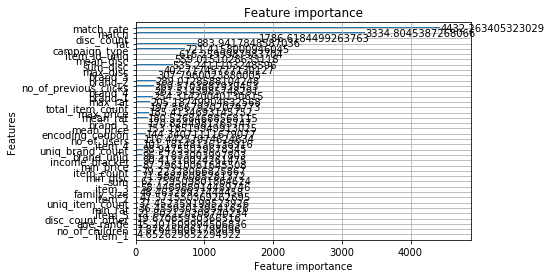

In [146]:
lgb.plot_importance(model,importance_type='gain')

In [151]:
relevant_transactions['ratio']=abs(relevant_transactions['coupon_discount']/relevant_transactions['selling_price'])
customer_uniq_item_count=relevant_transactions.groupby(['customer_id'])['item_id'].nunique().reset_index()
customer_uniq_item_count.columns=['customer_id','uniq_item_count']
customer_item_count=relevant_transactions.groupby(['customer_id'])['item_id'].count().reset_index()
customer_item_count.columns=['customer_id','item_count']
customer_total_item_count=relevant_transactions.groupby('customer_id')['quantity'].sum().reset_index()
customer_total_item_count.columns=['customer_id','total_item_count']
discounts_count_coupon=relevant_transactions[relevant_transactions['coupon_discount']<0].groupby('customer_id')['coupon_discount'].count().reset_index()
discounts_count_coupon.columns=['customer_id','disc_count']
discounts_count_other=relevant_transactions[relevant_transactions['other_discount']<0].groupby('customer_id')['other_discount'].count().reset_index()
discounts_count_other.columns=['customer_id','disc_count_other']
cust_price=relevant_transactions.groupby(['customer_id'])['selling_price'].agg(['min','max','mean','sum']).reset_index()
cust_price.columns=['customer_id','min_price','max_price','mean_price','sum']
discounts_feats_coupon=relevant_transactions[relevant_transactions['coupon_discount']<0].groupby('customer_id')['coupon_discount'].agg(['min','max','mean','sum']).reset_index()
discounts_feats_coupon.columns=['customer_id','min_disc','max_disc','mean_disc','sum_disc']
mean_disc_to_price=relevant_transactions[relevant_transactions['coupon_discount']<0].groupby('customer_id')['ratio'].agg(['min','max','mean']).reset_index()
mean_disc_to_price.columns=['customer_id','min_rat','max_rat','mean_rat']
test_main=test_demo.merge(customer_uniq_item_count,on='customer_id',how='left')
test_main=test_main.merge(customer_item_count,on='customer_id',how='left')
test_main=test_main.merge(discounts_count_coupon,on='customer_id',how='left')
test_main=test_main.merge(discounts_count_other,on='customer_id',how='left')
test_main=test_main.merge(cust_price,on='customer_id',how='left')
test_main=test_main.merge(discounts_feats_coupon,on='customer_id',how='left')
test_main=test_main.merge(mean_disc_to_price,on='customer_id',how='left')
test_main=test_main.merge(customer_total_item_count,on='customer_id',how='left')
test_main['min_disc']=abs(test_main['min_disc'])
test_main['max_disc']=abs(test_main['max_disc'])
test_main['mean_disc']=abs(test_main['mean_disc'])
test_main['sum_disc']=abs(test_main['sum_disc'])
target_enc_test = df_target.groupby(by = ['coupon_id'])['redemption_status'].agg(['sum','count']).reset_index()
target_enc_test.columns = ['coupon_id',"target_sum","target_count"]
target_enc_test['encoding_coupon'] = target_enc_test.target_sum/target_enc_test.target_count
test_main=test_main.merge(target_enc_test,on='coupon_id',how='left')
test_main=test_main.merge(embeds_brand,on='coupon_id',how='left')
test_main=test_main.merge(embeds_item,on='coupon_id',how='left')
test_main=test_main.merge(unique_item_data,on='coupon_id',how='left')
test_main=test_main.merge(cp,on='coupon_id',how='left')
test_main=test_main.merge(target_enc1,on='coupon_id',how='left')
test_main['rat']=test_main['encoding_coupon']/test_main['encoding']
people_coupons1=df_fin[df_fin['redemption_status']==1].groupby('coupon_id')['customer_id'].nunique().reset_index()
people_coupons1.columns=['coupon_id','no_of_users']
test_main=test_main.merge(people_coupons1,on='coupon_id',how='left')
cpt=df_fin.groupby('customer_id')['redemption_status'].sum().reset_index()
cpt.columns=['customer_id','past_action']
test_main=(test_main.merge(cpt,on='customer_id',how='left'))
uniq_brands_t=relevant_transactions.groupby(['customer_id'])['brand'].nunique().reset_index()
uniq_brands_t.columns=['customer_id','uniq_brand_count']
test_main=(test_main.merge(uniq_brands_t,on='customer_id',how='left'))

In [152]:
it_level_t=customer_transaction_data.groupby(['customer_id'])['item_id'].nunique().reset_index()
it_level_t.columns=['customer_id','no_of_previous_clicks']
test_main=test_main.merge(it_level_t,on=['customer_id'],how='left')
list_items1=customer_transaction_data.groupby(['customer_id'])['item_id'].unique().reset_index()
list_items1.columns=['customer_id','all_items']
list_items1['all_items']=[list(h) for h in list_items1['all_items']]
test_main=test_main.merge(list_items1,on=['customer_id'],how='left')
cp_item1=coupon_item_data.groupby('coupon_id')['item_id'].unique().reset_index()
cp_item1.columns=['coupon_id','all_items_cp']
cp_item1['all_items_cp']=[list(h) for h in cp_item1['all_items_cp']]
test_main=test_main.merge(cp_item1,on=['coupon_id'],how='left')
match1=[]
for i in range(test_main.shape[0]):
    try:
        list11=test_main['all_items'][i]
        list21=test_main['all_items_cp'][i]
        val1=len((list(set(list11).intersection(list21))))
        match1.append(val1)
    except:
        match1.append(0)
        pass
test_main['match']=match1
test_main['match_rate']=test_main['match']/test_main['no_of_previous_clicks']

In [155]:
op=pd.DataFrame()
op['id']=test_main['id']
op['redemption_status']=model.predict(test_main[cols])
op.to_csv('op.csv',index=False)

In [144]:
# # Hyperparameter tuning
# param_dict={}
# space = {'max_depth': hp.choice('max_depth', np.arange(-1, 20,dtype=int)),
#          'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(10, 400,dtype=int)),
#          'min_sum_hessian_in_leaf': hp.choice('min_sum_hessian_in_leaf', np.arange(0, 15,dtype=int)),
#          'num_leaves': hp.choice('num_leaves', np.arange(2, 200, dtype=int)),
#          'bagging_freq': hp.choice('bagging_freq', np.arange(1, 20, dtype=int)),
#          'subsample': hp.uniform('subsample', 0, 1),
#          'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
#         'learning_rate': hp.uniform('learning_rate', 0.08, 0.2),
#         }


# def objective(space):
#     params = {
#         'min_sum_hessian_in_leaf': space['min_sum_hessian_in_leaf'],
#         'min_data_in_leaf':space['min_data_in_leaf'],
#             'num_leaves':space['num_leaves'],
#              'subsample': space['subsample'],
#             'colsample_bytree': space['colsample_bytree'],
#             'learning_rate':space['learning_rate'],
#             'silent': 1,
#             'verbose_eval': True,
#             "objective":"binary",
#         'device':'cpu',
#         "boosting":"gbdt",
#         'max_depth':space['max_depth'],
#         'bagging_freq':space['bagging_freq'],
#           'metric':"auc",
#     'boost_from_average':False,
#     }
#     lgtrain = lgb.Dataset(df_finn[cols], label=df_finn['redemption_status'],categorical_feature=['campaign_type','marital_status'])
#     cv = lgb.cv(params,
#                 lgtrain,metrics='auc',
#                 num_boost_round=15000,
#                 early_stopping_rounds=600,verbose_eval=500,folds=skf.split(df_finn))
#     au = (cv['auc-mean'][-1])
#     params['n_estimators']=len(cv['auc-mean'])
#     param_dict[au]=params
#     pickle.dump(param_dict,open('params','wb'))
#     print(params, file=open("output_lgb.txt", "a"))
#     print(params)
#     print('max='+str(max(param_dict.keys())))
#     print ('auc = ', au)
#     print(au, file=open("output_lgb.txt", "a"))
#     return{'loss': -au, 'status': STATUS_OK}


# trials = Trials()
# best = hyperopt.fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10000,
#             trials=trials
#             )

# print(best)

# fName = open('trials.pkl', 'w')
# pickle.dump(trials, fName)
# fName.close()